In [1]:
# %matplotlib inline
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'retina'

In [2]:
import jax
import jax.numpy as jnp
import gymnax
import flax
from gymnax_exchange.jaxrl.ppoRnnExecCont import ActorCriticRNN
from gymnax_exchange.jaxrl.ppoRnnExecCont import ScannedRNN

from IPython.display import Image
from gymnax.visualize import Visualizer
import sys
import dataclasses
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import datetime as dt
import numpy as np

from gymnax_exchange.jaxen.exec_env import ExecutionEnv
sys.path.append('../purejaxrl')
from purejaxrl.wrappers import FlattenObservationWrapper, LogWrapper,ClipAction, VecEnv,NormalizeVecObservation,NormalizeVecReward

jax.device_count(), jax.devices()

I0000 00:00:1707927818.207203 1910237 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Num Jax Devices: 1 Device List: [gpu(id=0)]
gpu


(1, [gpu(id=0)])

In [3]:
config = {
    # "LR": 1e-4, # 5e-4, #5e-5, #1e-4,#2.5e-5,
    # "ENT_COEF": 0.001, #0.001, 0, 0.1, 0.01, 0.001
    "NUM_ENVS": 1, #1024, #128, #64, 1000,
    # "TOTAL_TIMESTEPS": 1e8,  # 1e8, 5e7, # 50MIL for single data window convergence #,1e8,  # 6.9h
    # "NUM_MINIBATCHES": 2, #8, 4, 2,
    # "UPDATE_EPOCHS": 30, #5,
    # "NUM_STEPS": 512, #500,
    # "CLIP_EPS": 0.2,
    
    # "GAMMA": 0.99,
    # "GAE_LAMBDA": 1.0, #0.95,
    # "VF_COEF": 0.001, #1.0, 0.5,
    # "MAX_GRAD_NORM": 10,# 0.5, 2.0,
    # "ANNEAL_LR": True, #True,
    "NORMALIZE_ENV": True,  # only norms observations (not reward)
    
    "ACTOR_TYPE": "RNN",
    "ACTION_NOISE_COLOR": 1,
    
    "ENV_NAME": "alphatradeExec-v0",
    "WINDOW_INDEX": 2, # 2 fix random episode #-1,
    "DEBUG": True,
    
    "TASKSIDE": "random", # "random", "buy", "sell"
    "REWARD_LAMBDA": 1., #0.001,
    "ACTION_TYPE": "pure", # "delta"
    "MAX_TASK_SIZE": 500,
    "TASK_SIZE": 500, # 500,
    "EPISODE_TIME": 60 * 1, # 1 minute
    "DATA_TYPE": "fixed_time", # "fixed_time", "fixed_steps"
    
    "ATFOLDER": "./training_oneDay/", #"/homes/80/kang/AlphaTrade/training_oneDay/",
    # "ATFOLDER": "./training_oneMonth", #"/homes/80/kang/AlphaTrade/training_oneDay/",
    # "RESULTS_FILE": "training_runs/results_file_"+f"{timestamp}",  # "/homes/80/kang/AlphaTrade/results_file_"+f"{timestamp}",
    # "CHECKPOINT_DIR": "training_runs/checkpoints_01-10_13-05/",
    "CHECKPOINT_DIR": "training_runs/checkpoints_02-14_15-29/",
    # "PARAMS_FILES": "training_runs/checkpoints_01-10_13-05/checkpoint_99091000.ckpt",
    # "PARAMS_FILES": "training_runs/checkpoints_01-12_15-18/checkpoint_525000.ckpt",
    "PARAMS_FILES": "training_runs/checkpoints_02-14_15-29/checkpoint_4195000.ckpt",
}

In [4]:
import glob
glob.glob("training_runs/checkpoints_02-14_15-29/*")

['training_runs/checkpoints_02-14_15-29/checkpoint_2098000.ckpt',
 'training_runs/checkpoints_02-14_15-29/checkpoint_525000.ckpt',
 'training_runs/checkpoints_02-14_15-29/checkpoint_2622000.ckpt',
 'training_runs/checkpoints_02-14_15-29/checkpoint_3147000.ckpt',
 'training_runs/checkpoints_02-14_15-29/checkpoint_6817000.ckpt',
 'training_runs/checkpoints_02-14_15-29/checkpoint_11011000.ckpt',
 'training_runs/checkpoints_02-14_15-29/checkpoint_4195000.ckpt',
 'training_runs/checkpoints_02-14_15-29/checkpoint_13633000.ckpt',
 'training_runs/checkpoints_02-14_15-29/checkpoint_10487000.ckpt',
 'training_runs/checkpoints_02-14_15-29/checkpoint_5244000.ckpt',
 'training_runs/checkpoints_02-14_15-29/checkpoint_13108000.ckpt',
 'training_runs/checkpoints_02-14_15-29/checkpoint_1050000.ckpt',
 'training_runs/checkpoints_02-14_15-29/checkpoint_7341000.ckpt',
 'training_runs/checkpoints_02-14_15-29/checkpoint_3671000.ckpt',
 'training_runs/checkpoints_02-14_15-29/checkpoint_6292000.ckpt',
 'train

In [36]:
rng = jax.random.PRNGKey(0)
rng, key_reset, key_policy, key_step = jax.random.split(rng, 4)

# alphatradePath, task, window_index, action_type, max_task_size, data_type
env = ExecutionEnv(
    alphatradePath=config["ATFOLDER"],
    task=config["TASKSIDE"],
    window_index=config["WINDOW_INDEX"],
    action_type=config["ACTION_TYPE"],
    max_task_size=config["MAX_TASK_SIZE"],
    rewardLambda=config["REWARD_LAMBDA"],
    ep_type=config["DATA_TYPE"],
)

# network input is automatically normalized (on top of env normalization)
# if config["NORMALIZE_ENV"]:
#     env = NormalizeVecObservation(env)

env_params = dataclasses.replace(
    env.default_params,
    reward_lambda=config["REWARD_LAMBDA"],
    task_size=config["TASK_SIZE"],
    episode_time=config["EPISODE_TIME"],
)
# Inspect default environment settings
# env_params

Num Jax Devices: 1 Device List: [gpu(id=0)]
START:  pre-reset in the initialization
pre-reset will be saved to  ./training_oneDay/_ExecutionEnv_stateArray_idx_2_dtype_"fixed_time"_depth_10.pkl
LOAD FROM PKL
FINISH: pre-reset in the initialization


In [34]:
class ExecVisualizer(Visualizer):
    def __init__(self, env, env_params, state_seq, action_seq, reward_seq=None):
        self.env = env
        self.env_params = env_params
        self.state_seq = state_seq
        self.action_seq = action_seq
        self.reward_seq = reward_seq  # jnp.concatenate((jnp.array([0]), reward_seq))
        self.interval = 1000
        
        # self.fig, self.ax = plt.subplots(3, 1, figsize=(7,5), gridspec_kw={'height_ratios': [1, 1, 5]})
        self.fig = plt.figure(figsize=(7, 5))
        outer = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 5])
        inner = gridspec.GridSpecFromSubplotSpec(
            1, 2, 
            subplot_spec=outer[2], 
            width_ratios=[1, 8],
            wspace=0.
        )
        # self.ax = [
        #     plt.Subplot(self.fig, outer[0]),
        #     plt.Subplot(self.fig, outer[1]),
        #     plt.Subplot(self.fig, inner[0]),
        #     plt.Subplot(self.fig, inner[1]),
        # ]
        # for ax in self.ax[:-1]:
        #     self.fig.add_subplot(ax)
        # self.fig.add_subplot(self.ax[-1], sharey=self.ax[-2])

        self.ax = [
            self.fig.add_subplot(plt.Subplot(self.fig, outer[0])),
            self.fig.add_subplot(plt.Subplot(self.fig, outer[1])),
            self.fig.add_subplot(plt.Subplot(self.fig, inner[0])),
        ]
        self.ax.append(
            self.fig.add_subplot(
                plt.Subplot(self.fig, inner[1], sharey=self.ax[-1]),
            )
        )

        # plt.setp(self.ax[-1].get_yticklabels(), visible=False)
        
    def init(self):
        # self.fig.tight_layout(rect=(0.02, 0.03, 1.0, 0.95))
        pass

    def ts_plot(self):
        # fig = plt.figure(figsize=(7, 5))
        fig, ax = plt.subplots(3, 1, figsize=(7,5), gridspec_kw={'height_ratios': [1, 1, 1]}, sharex=True)
        asks = np.array([ask / 1e4 for s in self.state_seq for ask in s.best_asks[:, 0]])
        bids = np.array([bid / 1e4 for s in self.state_seq for bid in s.best_bids[:, 0]])
        steps = np.cumsum(np.array([len(s.best_asks) for s in self.state_seq])) - 1
        # times = [dt.timedelta(seconds=float(s.time[0]), microseconds=float(s.time[1]) / 1e3) for s in self.state_seq]
        
        # PRICE PLOT
        ax[0].step(np.arange(len(asks)), asks, label='best ask', where='post')
        ax[0].step(np.arange(len(bids)), bids, label='best bid', where='post')
        ax[0].scatter(steps, (bids[steps] + asks[steps]) / 2, marker='x', label='steps', color='black')
        ax[0].set_title('Prices')
        ax[0].legend()

        # EXECUTION CURVE
        ax[1].step(steps, np.array([s.quant_executed for s in self.state_seq]), label='executed', where='post')
        ax[1].plot(steps, np.array([s.task_to_execute for s in self.state_seq]), label='task size')
        ax[1].set_title('Execution Curve')

        # CUMULATIVE REWARD
        ax[2].step(steps, self.reward_seq, label='reward', where='post')
        ax[2].set_title('Cumulative Reward')

    def update(self, frame):
        # obs_dict = self.env.unflatten_obs(self.obs_seq[frame])
        self._update_exec(self.env, self.state_seq[frame], self.action_seq[frame], self.env_params)
        is_sell_task = self.state_seq[frame].is_sell_task

        if self.reward_seq is None:
            self.fig.suptitle(
                f"{'SELL' if is_sell_task else 'BUY'} - Step {frame + 1}", fontsize=15
            )
        else:
            self.fig.suptitle(
                "{}: Step {:4.0f} - Return {:7.2f}".format(
                    'SELL' if is_sell_task else 'BUY',
                    frame + 1,
                    self.reward_seq[frame]
                ),
                fontsize=15,
            )

    def _update_exec(self, env, state, action, env_params):
        def buy_task_prices(best_ask, best_bid):
            FT = best_ask
            # mid defaults to one tick more passive if between ticks
            M = ((best_bid + best_ask)*1e4 // 2 // env.tick_size) * env.tick_size / 1e4
            NT = best_bid
            PP = (best_bid - env.tick_size*env.n_ticks_in_book / 1e4)
            return FT, M, NT, PP

        def sell_task_prices(best_ask, best_bid):
            FT = best_bid
            # mid defaults to one tick more passive if between ticks
            M = (jnp.ceil((best_bid + best_ask) * 1e4 / 2 / env.tick_size)
                 * env.tick_size)  / 1e4
            NT = best_ask
            PP = (best_ask + env.tick_size*env.n_ticks_in_book / 1e4)
            return FT, M, NT, PP

        obs = self.env._get_obs(state, self.env_params, flatten=False, normalize=False)
        print('obs from state', obs)
        print('action', action)

        # AX0: TIME REMAINING
        ax = self.ax[0]
        ax.clear()
        ax.barh(y=0, width=obs['time_remaining'], height=1)
        ax.set_xlim(0, env_params.episode_time)
        ax.set_yticks([])
        # ax.set_title('time remaining')
        ax.text(0.5, 0.5, 'time remaining', ha='center', va='center', transform=ax.transAxes)

        # AX1: TASK REMAINING
        ax = self.ax[1]
        ax.clear()
        ax.barh(y=0, width=obs['task_size'] - obs['executed_quant'], height=1)
        ax.set_xlim(0, env_params.task_size)
        ax.set_yticks([])
        # ax.set_title('quantity remaining')
        ax.text(0.5, 0.5, 'quantity remaining', ha='center', va='center', transform=ax.transAxes)

        # AX2 ACTIONS
        ax = self.ax[2]
        ax.clear()
        ax.set_xticks([])
        plt.setp(ax.get_yticklabels(), visible=True)

        ask_price, ask_size = state.best_asks[-1, 0] / 1e4, state.best_asks[-1, 1]
        bid_price, bid_size = state.best_bids[-1, 0] / 1e4, state.best_bids[-1, 1]
        spread = ask_price - bid_price
        bar_height = min(spread, .05)

        # PRICES
        if state.is_sell_task:
            passive_price = ask_price + env.tick_size*env.n_ticks_in_book / 1e4
            FT, M, NT, PP = sell_task_prices(ask_price, bid_price)
        else:
            passive_price = bid_price - env.tick_size*env.n_ticks_in_book / 1e4
            FT, M, NT, PP = buy_task_prices(ask_price, bid_price)

        # get action prices and quantities
        # ax.plot(1, FT, label='FT', marker='x', markersize=15, color="red")
        # ax.plot(1, M, label='M', marker='x', markersize=15, color="yellow")
        # ax.plot(1, NT, label='NT', marker='x', markersize=15, color="green")
        # ax.plot(1, PP, label='PP', marker='x', markersize=15, color="blue")
        if action is not None:
            ax.text(0, FT, f"{action[0]:02}", color="red", va='center', ha='left')
            ax.text(0, M, f"{action[1]:02}", color="orange", va='center', ha='left')
            ax.text(0, NT, f"{action[2]:02}", color="green", va='center', ha='left')
            ax.text(0, PP, f"{action[3]:02}", color="blue", va='center', ha='left')
        
        # AX3 BOOK STATE
        ax = self.ax[3]
        ax.clear()
        plt.setp(ax.get_yticklabels(), visible=False)
        # ax.set_yticks([])

        # bid and ask bars
        ax.barh(y=ask_price, width=ask_size, height=bar_height)
        ax.barh(y=bid_price, width=bid_size, height=bar_height)
        ax.text(1, ask_price, f"{ask_price:.2f}", va='center')
        ax.text(1, bid_price, f"{bid_price:.2f}", va='center')
        
        ax.barh(y=passive_price, width=1, height=bar_height)
        ax.text(1, passive_price, f"TODO", va='center')

        # add marker for init price
        init_price = obs['init_price'] / 1e4
        marker_y_loc = jnp.clip(init_price, bid_price - 5*spread, ask_price + 5*spread)
        arrow = '↑' if init_price > marker_y_loc else ('↓' if init_price < marker_y_loc else ' ')
        marker = "^" if init_price > marker_y_loc else ("v" if init_price < marker_y_loc else "o")
        ax.plot(1, marker_y_loc, label='init price', marker=marker, markersize=10, color="red")
        ax.text(1, marker_y_loc, f"{arrow} {init_price:.2f}", va='center', ha='left')
        ax.legend()

        ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f'))

        # self.fig.tight_layout()

In [26]:
# directory = config['CHECKPOINT_DIR']
# params_file = directory + '/'

In [27]:
directory = config['CHECKPOINT_DIR']
params_file = config['PARAMS_FILES']

with open(params_file, 'rb') as f:
    trainstate_params = flax.serialization.from_bytes(flax.core.frozen_dict.FrozenDict, f.read())
    print(f"params restored")

params restored


In [98]:
# network_config = (network, trainstate_params, env, env_params, key_step)

In [99]:
# ac_in = (obs[np.newaxis,np.newaxis, :], jnp.array([done])[np.newaxis, :])
# assert len(ac_in[0].shape) == 3, f"{ac_in[0].shape}"
# assert len(ac_in[1].shape) == 2, f"{ac_in[1].shape}"
# hstate, pi, value = network.apply(trainstate_params, hstate, ac_in) 

# Visualize Episode Rollout

In [9]:
trainstate_params['params']['Dense_0']['kernel'].shape

(21, 128)

In [37]:
# POLICY ACTIONS

state_seq, action_seq, reward_seq = [], [], [0]
rng, rng_reset = jax.random.split(rng)

last_obs, env_state = env.reset(rng_reset, env_params)
state_seq.append(env_state)
network = ActorCriticRNN(env.action_space(env_params).shape[0], config=config)
hstate = ScannedRNN.initialize_carry(config["NUM_ENVS"], 128)
hstate = hstate[None, :]  # TBH
last_done = jnp.zeros((config["NUM_ENVS"]), dtype=bool)

t_counter = 0
while True:
    # state_seq.append(env_state)
    rng, rng_act, rng_step = jax.random.split(rng, 3)
    
    # runner_state = (trainstate_params, env_state, last_obs, done, hstate, rng)

    # SELECT ACTION
    ac_in = (last_obs[np.newaxis, np.newaxis, :], last_done[np.newaxis, np.newaxis, :])
    # print('hstate', hstate.shape)
    # print('ac_in', ac_in[0].shape, ac_in[1].shape)
    hstate, pi, value = network.apply(trainstate_params, hstate, ac_in)
    rng, _rng = jax.random.split(rng)
    action = pi.sample(seed=_rng).squeeze()
    print('action', action)

    # action = env.action_space(env_params).sample(rng_act)
    action_seq.append(action)
    next_obs, next_env_state, reward, done, info = env.step_env(
        rng_step, env_state, action, env_params
    )
    state_seq.append(next_env_state)

    reward_seq.append(reward)
    t_counter += 1
    if done: # or t_counter >= 50:
        # state_seq.append(next_env_state)
        action_seq.append(None)
        break
    else:
        last_obs = next_obs
        env_state = next_env_state

cum_rewards = jnp.cumsum(jnp.array(reward_seq))

action [ 3.9986916   0.48843336 64.698616   34.46286   ]
action [ -2.875558 -19.630049  19.439518 -20.726639]
action [-19.335592 -19.352062  25.360006 -19.48538 ]
action [ 13.844871  -35.70214    36.360256   -1.2930875]
action [-11.697952  -23.060705   37.03598    -7.2125554]
action [-10.166191  -13.093058   34.359      -6.4906173]
action [-10.290549 -31.967554  36.36399  -21.989695]
action [-18.617075 -21.09452   45.91127  -13.639181]
action [-12.168543  -43.72413    50.894012   -5.9775963]
action [ -7.992199  -15.3173485  46.46086    -6.428013 ]
action [ -6.3847833 -33.837395   30.852997   -3.3685796]
action [  5.312686 -28.559645   9.242697  18.57056 ]
action [ 14.0538435 -14.676748   29.680641   13.093537 ]
action [-12.011749 -16.179138  31.048943  42.614235]
action [ -6.9897885 -17.950172   37.69451    22.310642 ]
action [ 6.0691586 -9.931985  18.781925   3.326479 ]


In [44]:
# asks = [ask / 1e4 for s in state_seq for ask in s.best_asks[:, 0]]
# bids = [bid / 1e4  for s in state_seq for bid in s.best_bids[:, 0]]

In [39]:
last_obs.shape

(21,)

In [16]:
state_seq[0].__dict__.keys()

dict_keys(['ask_raw_orders', 'bid_raw_orders', 'trades', 'init_time', 'time', 'customIDcounter', 'window_index', 'step_counter', 'max_steps_in_episode', 'start_index', 'prev_action', 'prev_executed', 'best_asks', 'best_bids', 'init_price', 'task_to_execute', 'quant_executed', 'total_revenue', 'slippage_rm', 'price_adv_rm', 'price_drift_rm', 'vwap_rm', 'is_sell_task'])

In [17]:
state_seq[-1].quant_executed

Array(500, dtype=int32)

In [18]:
state_seq[-1].__dict__.keys()

dict_keys(['ask_raw_orders', 'bid_raw_orders', 'trades', 'init_time', 'time', 'customIDcounter', 'window_index', 'step_counter', 'max_steps_in_episode', 'start_index', 'prev_action', 'prev_executed', 'best_asks', 'best_bids', 'init_price', 'task_to_execute', 'quant_executed', 'total_revenue', 'slippage_rm', 'price_adv_rm', 'price_drift_rm', 'vwap_rm', 'is_sell_task'])

In [13]:
state_seq[-1].task_to_execute

Array(500, dtype=int32, weak_type=True)

In [40]:
reward_seq

[0,
 Array(-0.0605, dtype=float32),
 Array(-0.73910004, dtype=float32),
 Array(-1.13, dtype=float32),
 Array(-1.6769, dtype=float32),
 Array(-1.5984001, dtype=float32),
 Array(-1.2308, dtype=float32),
 Array(-0.96840006, dtype=float32),
 Array(0.2944, dtype=float32),
 Array(1.3872001, dtype=float32),
 Array(1.8124001, dtype=float32),
 Array(1.3764001, dtype=float32),
 Array(0.3582, dtype=float32),
 Array(1.0320001, dtype=float32),
 Array(0.75640005, dtype=float32),
 Array(0.61600006, dtype=float32),
 Array(-0.47280002, dtype=float32)]

MovieWriter ffmpeg unavailable; using Pillow instead.


obs from state {'is_sell_task': Array(1, dtype=int32), 'p_aggr': Array(31250100, dtype=int32), 'p_pass': Array(31261100, dtype=int32), 'spread': Array(11000, dtype=int32), 'q_aggr': Array(11, dtype=int32), 'q_pass': Array(39, dtype=int32), 'time': Array(34320.062, dtype=float32, weak_type=True), 'time_remaining': Array(59.9375, dtype=float32, weak_type=True), 'init_price': Array(31255600, dtype=int32), 'task_size': Array(500, dtype=int32, weak_type=True), 'executed_quant': Array(0, dtype=int32, weak_type=True), 'step_counter': Array(0, dtype=int32, weak_type=True), 'max_steps': Array(439, dtype=int32), 'prev_action': Array([0, 0, 0, 0], dtype=int32), 'prev_executed': Array([0, 0, 0, 0], dtype=int32)}
action [ 3.9986916   0.48843336 64.698616   34.46286   ]
obs from state {'is_sell_task': 1, 'p_aggr': Array(31216700, dtype=int32), 'p_pass': Array(31220000, dtype=int32), 'spread': Array(3300, dtype=int32), 'q_aggr': Array(3, dtype=int32), 'q_pass': Array(104, dtype=int32), 'time': Array(

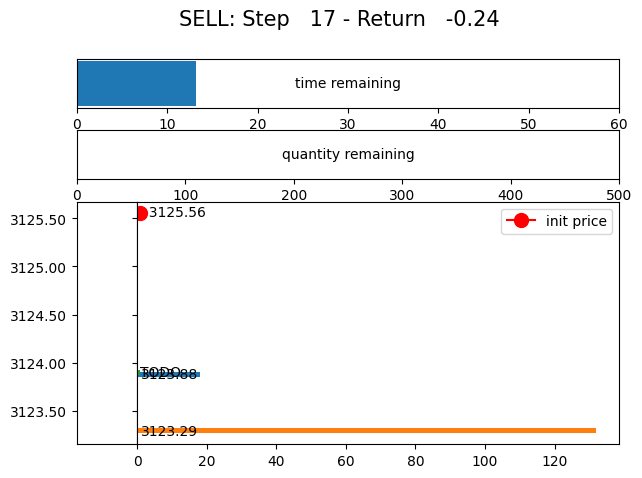

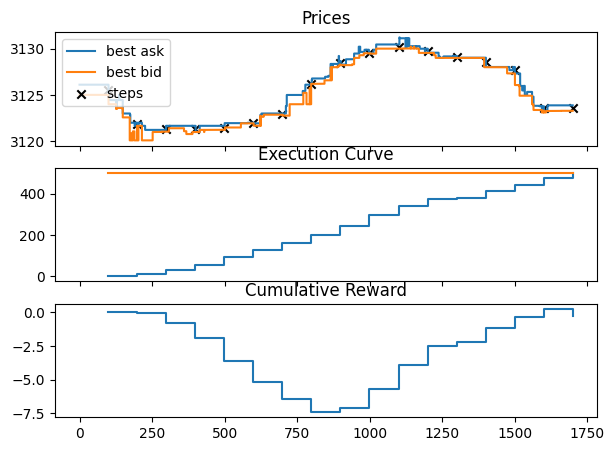

In [41]:
vis = ExecVisualizer(env, env_params, state_seq, action_seq, cum_rewards)
vis.animate(f"anim.gif")
vis.ts_plot()
# vis.animate()

In [76]:
state_seq[-1].quant_executed

Array(126, dtype=int32)

In [77]:
len(state_seq), len(reward_seq)

(23, 23)

In [78]:
# reward is actually next state reward --> plot later, start with 0
for s, r in zip(state_seq, reward_seq):
    print(s.quant_executed, r)

0 0
10 0.055000003
10 0.0
10 0.0
19 -0.324
27 -0.28800002
27 0.0
27 0.0
36 0.1098
36 0.0
36 0.0
36 0.0
44 0.2976
86 1.4826001
96 0.3287
96 0.0
96 0.0
104 -0.1808
111 -0.16550002
111 0.0
112 -0.0401
123 -0.38610002
126 -0.110400006


In [58]:
# TODO: 
# add ACTUAL action to the next observation (--> positive integer value with cutoffs)
# add number of executed shares to the next observation
# (!) plot executions per price level over time
# measure percentage of liquidity taken & provided over time (marketable: order size / available at level ; passive: order size / size at the level incl. own order)
# drift as additional observation (on top of init price)??

In [19]:
# RANDOM ACTION

state_seq, action_seq, reward_seq = [], [], []
rng, rng_reset = jax.random.split(rng)
obs, env_state = env.reset(rng_reset, env_params)
t_counter = 0
while True:
    state_seq.append(env_state)
    rng, rng_act, rng_step = jax.random.split(rng, 3)
    
    # random action sampling
    action = env.action_space(env_params).sample(rng_act)
    action_seq.append(action)
    next_obs, next_env_state, reward, done, info = env.step(
        rng_step, env_state, action, env_params
    )
    reward_seq.append(reward)
    t_counter += 1
    if done: # or t_counter >= 50:
        # state_seq.append(next_env_state)
        # action_seq.append(None)
        break
    else:
        obs = next_obs
        env_state = next_env_state

cum_rewards = jnp.cumsum(jnp.array(reward_seq))
vis = ExecVisualizer(env, env_params, state_seq, action_seq, cum_rewards)
vis.animate(f"anim.gif")
vis.ts_plot()
# vis.animate()

W0000 00:00:1706203770.359148   74936 graph_launch.cc:158] Evict all gpu graphs from executor 0x7f43580015c0
2024-01-25 17:29:30.433162: W external/xla/xla/service/gpu/runtime/support.cc:58] Intercepted XLA runtime error:
RESOURCE_EXHAUSTED: Failed to get module function:CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-01-25 17:29:30.433229: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2644] Execution of replica 0 failed: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.func.launch' failed: Failed to get module function:CUDA_ERROR_OUT_OF_MEMORY: out of memory; current tracing scope: wrapped_add.1520; current profiling annotation: XlaModule:#hlo_module=jit_step,program_id=281#.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:14                                                                                   │
│                                                                                                  │
│   11 │   # random action sampling                                                                │
│   12 │   action = env.action_space(env_params).sample(rng_act)                                   │
│   13 │   action_seq.append(action)                                                               │
│ ❱ 14 │   next_obs, next_env_state, reward, done, info = env.step(                                │
│   15 │   │   rng_step, env_state, action, env_params                                             │
│   16 │   )                                                                                       │
│   17 │   reward_seq.append(reward)                                                               │
│                                                                                                  │
│ /nfs/home/peern/miniconda3/envs/rl_exec/lib/python3.10/site-packages/jax/_src/traceback_util.py: │
│ 177 in reraise_with_filtered_traceback                                                           │
│                                                                                                  │
│   174   def reraise_with_filtered_traceback(*args, **kwargs):                                    │
│   175 │   __tracebackhide__ = True                                                               │
│   176 │   try:                                                                                   │
│ ❱ 177 │     return fun(*args, **kwargs)                                                          │
│   178 │   except Exception as e:                                                                 │
│   179 │     mode = _filtering_mode()                                                             │
│   180 │     if _is_under_reraiser(e) or mode == "off":                                           │
│                                                                                                  │
│ /nfs/home/peern/miniconda3/envs/rl_exec/lib/python3.10/site-packages/jax/_src/pjit.py:255 in     │
│ cache_miss                                                                                       │
│                                                                                                  │
│    252                                                                                           │
│    253   @api_boundary                                                                           │
│    254   def cache_miss(*args, **kwargs):                                                        │
│ ❱  255 │   outs, out_flat, out_tree, args_flat, jaxpr = _python_pjit_helper(                     │
│    256 │   │   fun, infer_params_fn, *args, **kwargs)                                            │
│    257 │   executable = _read_most_recent_pjit_call_executable(jaxpr)                            │
│    258 │   fastpath_data = _get_fastpath_data(executable, out_tree, args_flat, out_flat)         │
│                                                                                                  │
│ /nfs/home/peern/miniconda3/envs/rl_exec/lib/python3.10/site-packages/jax/_src/pjit.py:166 in     │
│ _python_pjit_helper                                                                              │
│                                                                                                  │
│    163   for arg in args_flat:                                                                   │
│    164 │   dispatch.check_arg(arg)                                                               │
│    165   try:                                                                                    │
│ ❱  166 │   out_flat = pjit_p.bind(*args_flat, **params)    

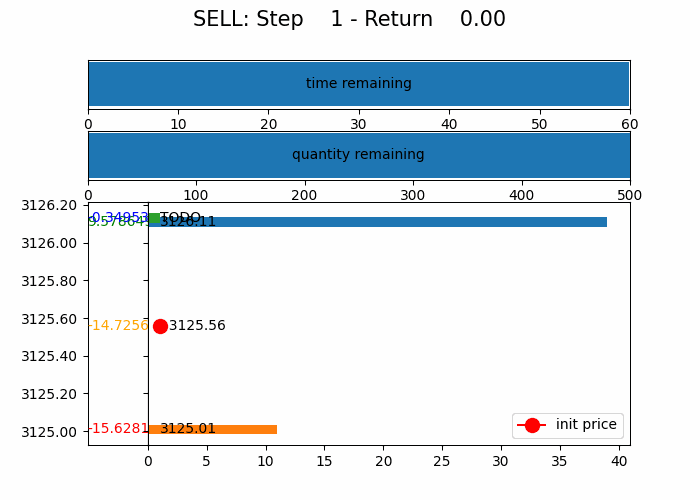

In [80]:
display(Image(data=open('anim.gif','rb').read(), format='gif'))

In [ ]:
# from IPython.display import Image
# Image(url='anim.gif')